### Boosting  
可以将几个弱学习器结合成一个强学习器的任意集成方式  
最常见的算法为  
- XGboost 
- LightGBM
- CatBoost

#### 一.XGBoost  
XGBoost是GBDT的改进版本，引入了正则化项和二阶导数信息，提升了效率和精度。其核心思想是通过逐步添加决策树来最小化损失函数。XGBoost 的损失函数由两部分组成：损失函数（Loss Function）和正则化项（Regularization Term）

##### 1.1 损失函数  
假设我们有一个数据集$D=\{(x_i,y_i)\}_{i=1}^N$，其中$x_i$是样本特征，$y_i$是样本标签  


XGBoost的目标是通过逐步添加决策树来最小化损失函数  
$$L(y, \hat{y}) = \sum_{i=1}^nl(y_i - \hat{y_i})^2 + \sum_{j=1}^m\Omega(f_k)$$


其中：  
$n$是样本数量，$l$是损失函数，$\omega(f_k)$是第$k$棵树的正则化项

##### 1.2 正则化项
正则化项$\Omega(f_k)$通常包括两部分：叶子节点的权重和叶子节点的数量。具体形式如下



$$\Omega(f_k) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T\omega_j^2$$

其中：$\gamma$是正则化参数，$\lambda$是拉格朗日参数，$x$是输入向量，$y$是标签向量，$w$是权重向量，$b$是偏置向量，$L$是损失函数，$D$是数据集大小。

##### 1.3 树模型与分类方式  
XGBoost同样使用CART树，分裂时采用近似算法来加速计算  
$$G(D_m) = \sum_{i \in D_m} \left( \frac{1}{N_m} \sum_{j \in N_m} \left( \frac{1}{N_j} \sum_{k \in N_j} y_k \right) - \frac{1}{N_m} \sum_{j \in N_m} \left( \frac{1}{N_j} \sum_{k \in N_j} y_k \right) \right)$$


#### 二.LightGBM  
##### 2.1 Histogram
核心思想：将连续特征离散化为直方图  


##### 2.2 算法流程  
- 预处理：将每个特征的值映射到K个桶  
- 统计累加：遍历样本时，只需在对应桶上累加$g_i$和$h_i$  
- 寻找分裂点：只在桶边界上搜索，而非所有数据点


##### 2.3 GOSS策略 
1. 按梯度绝对值|$g_i$|排序 
2. 保留top a 的大梯度样本
3. 从剩余样本中随机采样b
4. 对小梯度样本乘以放大系数$\frac{1-a}{b}$,保证无偏

##### 2.4 EFB策略
将互斥特征（如果两个特征很少同时取非零值，则他们近似互斥）捆绑成一个特征，减少特征数量  
1. 构建图：特征为节点，非互斥特征间连边（冲突）  
2. 图着色：NP-hard问题，使用贪心近似  
3. 特征合并：同一颜色的特征捆绑


#### 三.Catboost
主要解决： 
- 类别特征处理：传统方法（One-hot、Target Encoding）各有缺陷
- 预测偏移：用相同数据计算梯度和训练模型导致过拟合

#### 3.1 Ordered Boosting 
每个样本的预测值，只用排在它前面的样本训练的模型计算

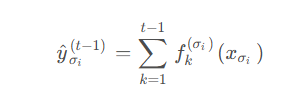

##### 3.2 Target Statistics 
用该类别的目标均值替换类别值  


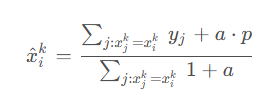

##### 3.3 Ordered Target Statistics  
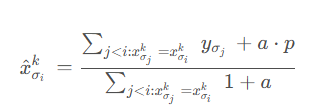

##### 3.4 对称树结构

            根
       /         \
      f1<5      f1>=5
     /    \    /     \
   f2<3  f2>=3 f2<3 f2>=3


- 每一层使用相同的分裂条件
- 所有叶子在同一深度
- 结构完全对称

#### 四.算法对比

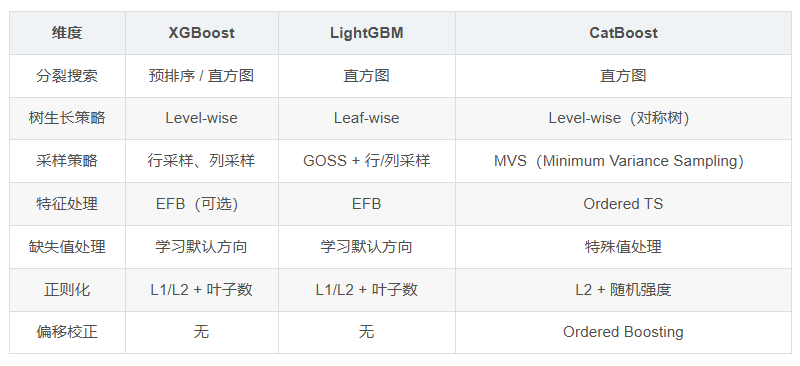

1. XGBoost 最佳场景
- 中小规模数据集（<100万样本）
- 需要精确控制模型的场景
- 对可解释性要求高
- 已有成熟的 XGBoost 部署流程
2. LightGBM 最佳场景
- 大规模数据集（百万级以上）
- 高维稀疏数据（如 CTR 预估）
- 需要快速迭代实验
- 内存资源受限
3. CatBoost 最佳场景
- 大量类别特征（如推荐系统的用户/物品 ID）
- 对过拟合敏感的场景
- 需要开箱即用、少调参
- 在线推理延迟敏感



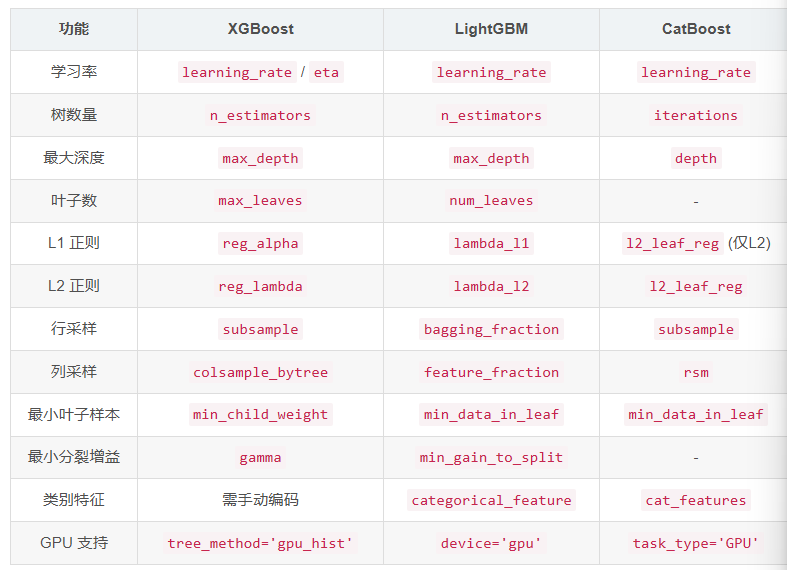

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [24]:
data = fetch_california_housing()
# 定义需要保留的数值特征（排除Latitude、Longitude）
keep_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
# 筛选特征：只保留指定的5个数值特征
X = pd.DataFrame(data.data, columns=data.feature_names)[keep_features]
y = data.target
print("保留的数值特征：")
print(X.columns.tolist())
print("原始数据形状（剔除经纬度后）：", X.shape)


保留的数值特征：
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
原始数据形状（剔除经纬度后）： (20640, 5)


In [ ]:
# 房屋类型：3分类
np.random.seed(42)
X['HouseType'] = np.random.choice(
    ['Apartment', 'House', 'Condo'], 
    size=len(X), 
    p=[0.4, 0.35, 0.25]
)

# 地段等级：4分类
X['LocationGrade'] = np.random.choice(
    ['A', 'B', 'C', 'D'], 
    size=len(X), 
    p=[0.1, 0.3, 0.4, 0.2]
)

print("添加分类特征后：")
print(X.columns.tolist())
print("\n分类特征取值：")
print("HouseType:", X['HouseType'].unique())
print("LocationGrade:", X['LocationGrade'].unique())

添加分类特征后：
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'HouseType', 'LocationGrade']

分类特征取值：
HouseType: ['Apartment' 'Condo' 'House']
LocationGrade: ['B' 'A' 'D' 'C']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
cat_cols = ['HouseType', 'LocationGrade']
print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (16512, 10)
Test: (4128, 10)


In [26]:
from sklearn.preprocessing import LabelEncoder
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

# 对分类特征做LabelEncoder编码（XGB不原生支持字符串分类特征）
for col in cat_cols:
    le = LabelEncoder()
    # 仅在训练集fit，避免数据泄露
    X_train_xgb[col] = le.fit_transform(X_train_xgb[col])
    X_test_xgb[col] = le.transform(X_test_xgb[col])

# XGBoost网格搜索调参
xgb_reg = xgb.XGBRegressor(
    random_state=42, 
    objective='reg:squarederror',
    verbosity=0  # 关闭日志
)
xgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150]
}

# 3折交叉验证，加速训练
xgb_grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # 使用所有CPU核心
    verbose=0
)

print("\n开始训练XGBoost模型...")
xgb_grid.fit(X_train_xgb, y_train)

# 最优模型预测
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test_xgb)

# 评估
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost最优参数：", xgb_grid.best_params_)
print(f"XGBoost - MSE: {xgb_mse:.4f}, R²: {xgb_r2:.4f}")


开始训练XGBoost模型...
XGBoost最优参数： {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
XGBoost - MSE: 0.2303, R²: 0.8243


In [27]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

for col in cat_cols:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

# LightGBM网格搜索调参
lgb_reg = lgb.LGBMRegressor(
    random_state=42,
    verbose=-1  # 关闭日志
)
lgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150],
    'num_leaves': [31]
}

lgb_grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=lgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

print("\n开始训练LightGBM模型...")
lgb_grid.fit(X_train_lgb, y_train)

# 最优模型预测
lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(X_test_lgb)

# 评估
lgb_mse = mean_squared_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print("LightGBM最优参数：", lgb_grid.best_params_)
print(f"LightGBM - MSE: {lgb_mse:.4f}, R²: {lgb_r2:.4f}")



开始训练LightGBM模型...
LightGBM最优参数： {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 31}
LightGBM - MSE: 0.2235, R²: 0.8294


In [28]:
cat_reg = CatBoostRegressor(
    random_state=42,
    verbose=0  
)
cat_param_grid = {
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'iterations': [150]
}

cat_grid = GridSearchCV(
    estimator=cat_reg,
    param_grid=cat_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

print("\n开始训练CatBoost模型...")
# 直接指定分类特征列名，CatBoost会自动处理
cat_grid.fit(X_train, y_train, cat_features=cat_cols)

# 最优模型预测
cat_best = cat_grid.best_estimator_
cat_pred = cat_best.predict(X_test)

# 评估
cat_mse = mean_squared_error(y_test, cat_pred)
cat_r2 = r2_score(y_test, cat_pred)

print("CatBoost最优参数：", cat_grid.best_params_)
print(f"CatBoost - MSE: {cat_mse:.4f}, R²: {cat_r2:.4f}")



开始训练CatBoost模型...
CatBoost最优参数： {'depth': 5, 'iterations': 150, 'learning_rate': 0.1}
CatBoost - MSE: 0.2540, R²: 0.8062


         模型       MSE        R²
1  LightGBM  0.223535  0.829416
0   XGBoost  0.230284  0.824266
2  CatBoost  0.253978  0.806184


C:\Users\23017\AppData\Local\Temp\ipykernel_20196\1713812226.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='模型', y='MSE', data=results, palette='Reds_r')
C:\Users\23017\AppData\Local\Temp\ipykernel_20196\1713812226.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='模型', y='R²', data=results, palette='Greens')
C:\Users\23017\AppData\Local\Temp\ipykernel_20196\1713812226.py:28: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
c:\Users\23017\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


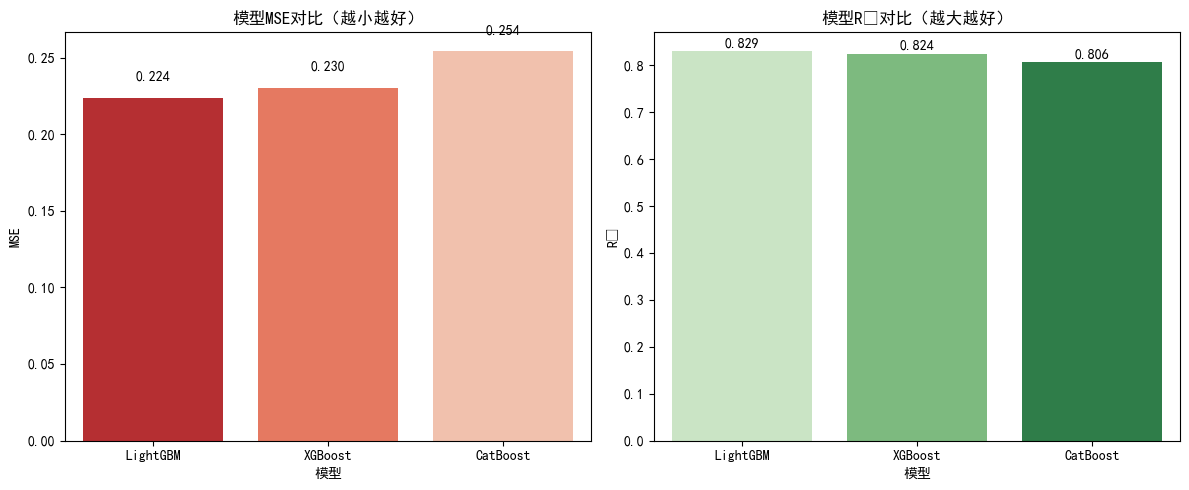

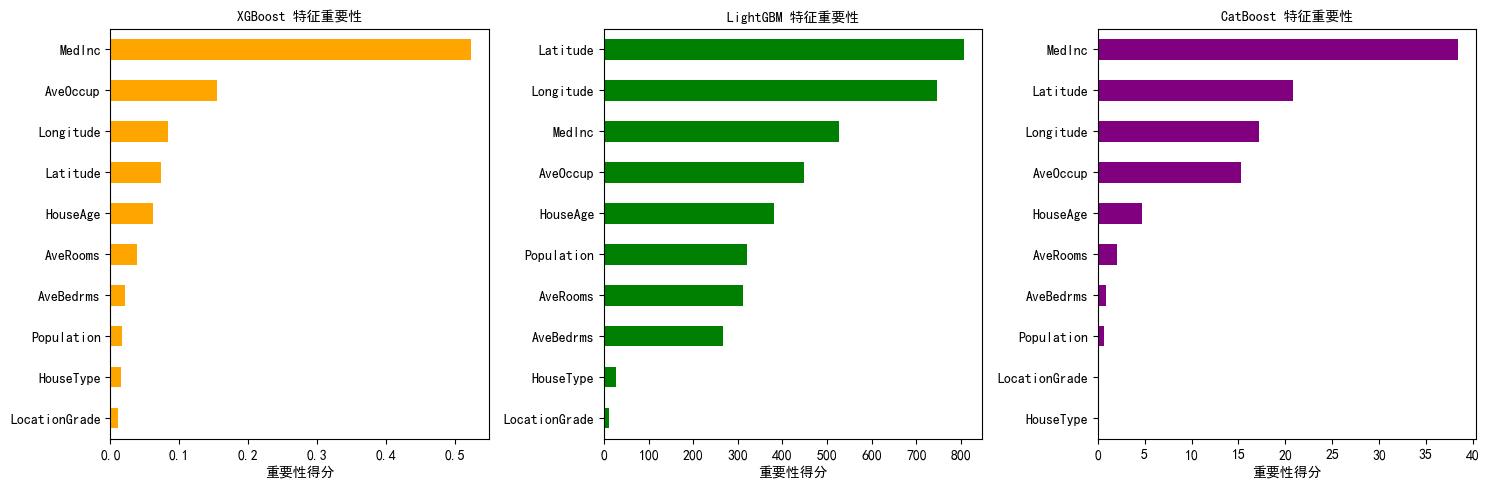

In [29]:
results = pd.DataFrame({
    '模型': ['XGBoost', 'LightGBM', 'CatBoost'],
    'MSE': [xgb_mse, lgb_mse, cat_mse],
    'R²': [xgb_r2, lgb_r2, cat_r2]
}).sort_values(by='R²', ascending=False)

print(results)

# 可视化MSE和R²对比
plt.figure(figsize=(12, 5))

# MSE对比
plt.subplot(1, 2, 1)
sns.barplot(x='模型', y='MSE', data=results, palette='Reds_r')
plt.title('模型MSE对比（越小越好）', fontsize=12)
# 标注数值
for i, v in enumerate(results['MSE']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# R²对比（越大越好）
plt.subplot(1, 2, 2)
sns.barplot(x='模型', y='R²', data=results, palette='Greens')
plt.title('模型R²对比（越大越好）', fontsize=12)
# 标注数值
for i, v in enumerate(results['R²']):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 5))

# XGBoost特征重要性
plt.subplot(1, 3, 1)
xgb_importance = pd.Series(xgb_best.feature_importances_, index=X_train_xgb.columns)
xgb_importance.sort_values().plot(kind='barh', color='orange')
plt.title('XGBoost 特征重要性', fontsize=10)
plt.xlabel('重要性得分')

# LightGBM特征重要性
plt.subplot(1, 3, 2)
lgb_importance = pd.Series(lgb_best.feature_importances_, index=X_train_lgb.columns)
lgb_importance.sort_values().plot(kind='barh', color='green')
plt.title('LightGBM 特征重要性', fontsize=10)
plt.xlabel('重要性得分')

# CatBoost特征重要性
plt.subplot(1, 3, 3)
cat_importance = pd.Series(cat_best.get_feature_importance(), index=X_train.columns)
cat_importance.sort_values().plot(kind='barh', color='purple')
plt.title('CatBoost 特征重要性', fontsize=10)
plt.xlabel('重要性得分')

plt.tight_layout()
plt.show()

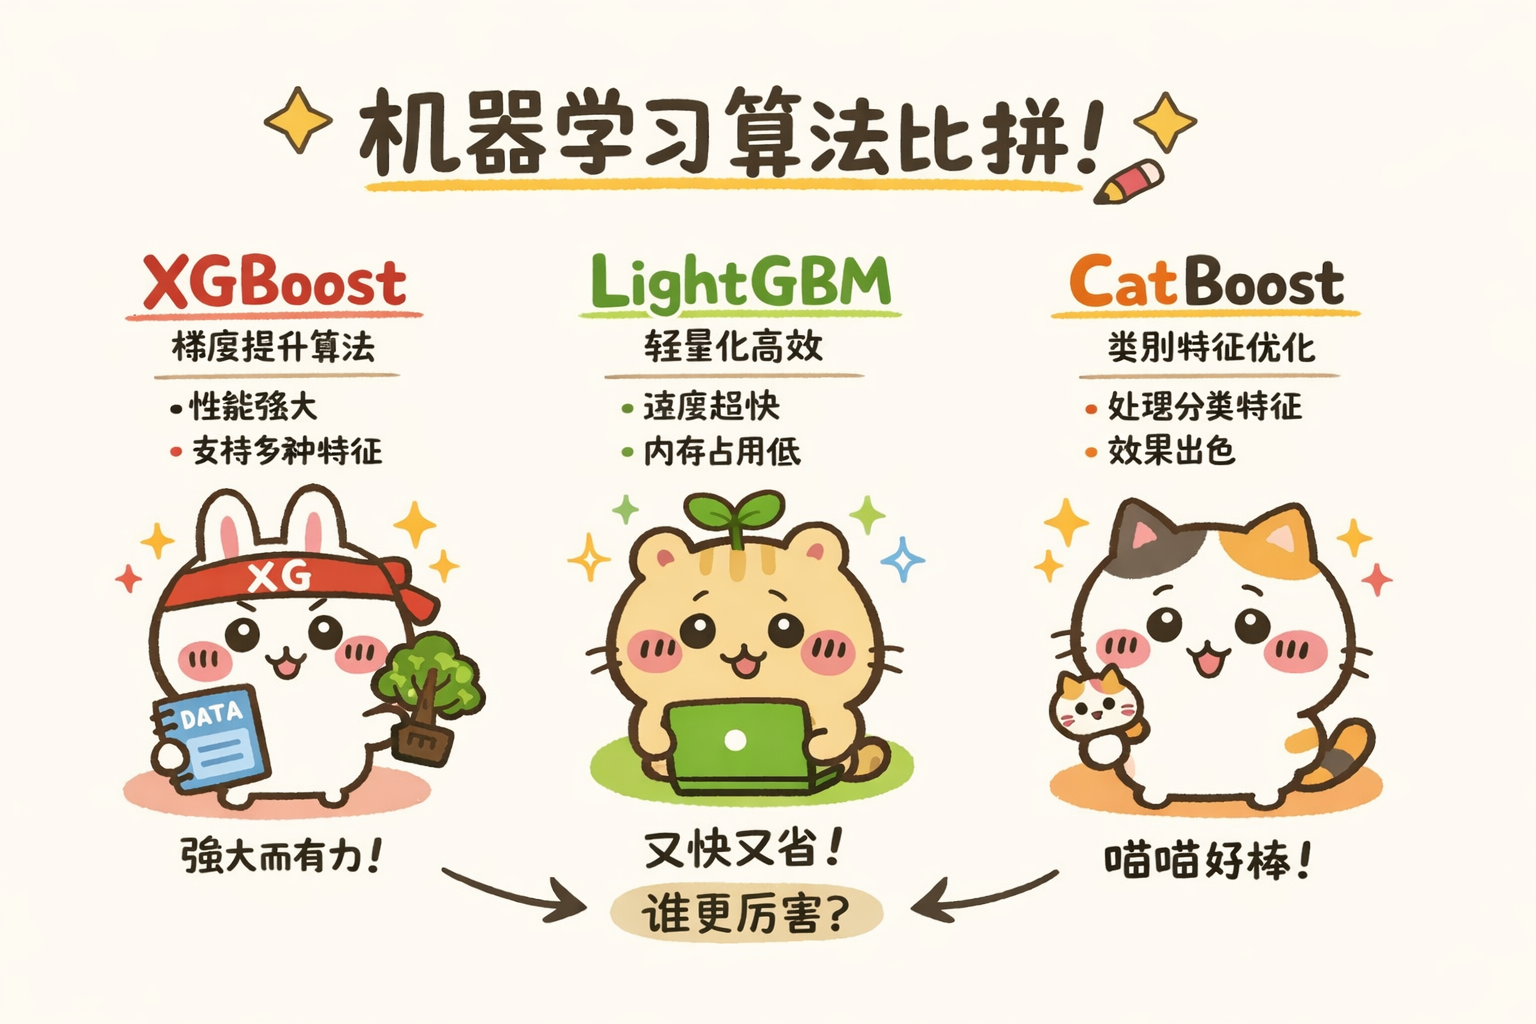